In [10]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

data_dir = os.path.join("../../../data/embeddings/")
imd_file = os.path.join("../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

### Get imd data

In [4]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Get embedding data

In [5]:
big_summary_df = pd.read_pickle(data_dir +"embedding_summaries/big_summary_df_CLIP.pkl")
big_summary_df_with_imd = pd.merge(left=big_summary_df, right=imd, on="LSOA21CD")
big_summary_df_with_imd['imd_rerank'] = big_summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

# Fit model

In [8]:
# define predictor and response variables
X = np.stack(big_summary_df_with_imd["overall_median"].values)     # shape (n_points, embed_dim)
y = big_summary_df_with_imd['imd_rerank'].values

# Define train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and run model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Feature importance

In [11]:
# Permutation
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

In [12]:
# Feature importance
importances = rf.feature_importances_  # shape: (embed_dim,)
indices = np.argsort(importances)[::-1]  # descending order

In [13]:
top_n =20
# Compute top 3 features by mean importance
sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]  # top 3
# Top FI
top_indices = indices[:top_n]
top_importances = importances[top_indices]

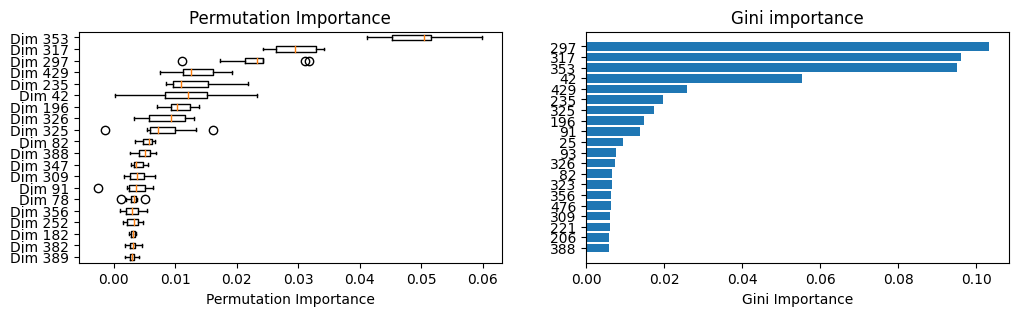

In [14]:
# Create boxplot
fig, axs = plt.subplots(ncols=2, figsize=(12, 3))

# Use transpose: (n_repeats x n_features)
axs[0].boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, 
           labels=[f"Dim {i}" for i in sorted_idx])  # labels = column indices
axs[0].set_xlabel("Permutation Importance")
axs[0].set_title(f"Permutation Importance");


# Create positions for bars
x_pos = np.arange(len(top_indices))
axs[1].barh(range(top_n), importances[indices][:top_n][::-1])
axs[1].set_yticks(range(top_n), indices[:top_n][::-1])
axs[1].set_xlabel("Gini Importance")
axs[1].set_title(f"Gini importance");